The following is a sample size analysis for this [Tax Career Agent Experiment](https://www.overcomingbias.com/2022/10/testing-tax-career-agents.html).

## Sample Size Estimate

Let's start with a study that lasts $k$ years, where everyone in the "treatment group" is assigned a tax career agent.

Consider one individual: say their (taxable inflation-adjusted) income after year $t$ is $E(t)$, and their original income (prior to the study) is $E(0)$.
(This could be an average over the previous 5 or 10 years.)

Define their "increase in income" over the study as:

$$
X = \log\left(\frac{\frac{1}{k}\sum_{t=1}^k E(t)}{E(0)}\right)
$$
if they're in the control group, or
$$
Y = \log\left(\frac{\frac{1}{k}\sum_{t=1}^k E(t)}{E(0)}\right)
$$
if they're in the treatment group (i.e. if they're assigned a tax career agent).

Let's assume that:
* $X \sim \mathcal{N}(\mu_0, \sigma^2)$ if they're in the control group, or
* $Y \sim \mathcal{N}(\mu_1, \sigma^2)$ if they're in the treatment group.

Let's also define:
* $\sigma_E$: the one-year volatility in earnings. This will be used to calculate $\sigma$, the standard deviation of change in income.
* $r$: the rate at which earnings grow per year with a tax career agent, above the rate at which they grow without one.

We want to estimate the sample size $n$ required to obtain a certain power $1 - \beta$.
Under the assumptions above, we can achieve this by inverting the [two-sample $t$-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test).

Let's use the following numbers:
* $k = 10$: the study lasts 10 years.
* $r = 0.03 / 10 = 0.003$: individuals' earnings grow at a rate 0.3% per year higher with tax career agents vs without. (See [here](https://www.overcomingbias.com/2022/10/needed-world-suggestion-box.html) for details of this estimate.)
* $\mu_1 - \mu_0 = (\frac{k + 1}{2})r = 0.0175$: the difference in means between changes in income for the treatment group, relative to the control group.
* $\sigma_E = 0.2$: the 1-year volatility of income. See Estimating Individual Income Volatility for details of this estimate.
* $\sigma = \sqrt{\frac{1}{6} \frac{(k + 1)(2k + 1)}{k}} \sigma_E = 0.39$: how much the *change* in individuals' incomes varies. See Estimating Variance in Change in Income for details. This is probably an underestimate.
* $1 - \beta = 0.8$: a true-positive probability of 80%.
* $p = 0.05$: a false-positive probability of 5%.

The effect size is then $(\mu_1 - \mu_0) / \sigma = 0.042$. The sample size for this effect size is shown below.

In [1]:
import math
from statsmodels.stats.power import tt_ind_solve_power

def compute_effect_size(study_duration, earnings_growth_rate, income_volatility):
    difference_in_means = (study_duration + 1) / 2 * earnings_growth_rate
    sd = math.sqrt(1 / 6 * (study_duration + 1) * (2 * study_duration + 1) / study_duration ) * income_volatility
    return difference_in_means / sd

In [2]:
# Default parameters
k = 10
r = 0.03 / 10
sigma_e = 0.2
power = 0.8
level = 0.05

effect_size_for_10yr_study = compute_effect_size(k, r, sigma_e)

In [3]:
print(effect_size_for_10yr_study)

0.04204589329360411


In [4]:
tt_ind_solve_power(effect_size=effect_size_for_10yr_study, alpha=level, power=power, alternative="larger")

6995.08474509833

Here are a few small variations:

In [5]:
# k = 5 years (instead of 10)
effect_size_for_5yr_study = compute_effect_size(5, r, sigma_e)
tt_ind_solve_power(effect_size=effect_size_for_5yr_study, alpha=level, power=power, alternative="larger")

13434.381192417293

In [6]:
# standard deviation of change in income σ ~ 0.8 (instead of 0.4)
# or: compound at r = 1.5% rather than 3%
# (they have the same effect)

tt_ind_solve_power(effect_size=effect_size_for_10yr_study / 2, alpha=level, power=power, alternative="larger")

27978.30945329945

In [7]:
# Require 95% power
tt_ind_solve_power(effect_size=effect_size_for_10yr_study, alpha=level, power=0.95, alternative="larger")

12243.944662491167

In [8]:
# Require 1% false-positive rate
tt_ind_solve_power(effect_size=effect_size_for_10yr_study, alpha=0.01, power=power, alternative="larger")

11355.244002683577

If only a fraction $f$ of the treatment group are actually assigned career agents, the effect size is just multiplied by this fraction $f$. So you need a larger sample (obviously).

Presumably you could also gather data about participants' age, sex, education etc. The better you can adjust for these, the smaller a sample you need (since presumably you can account for more variance in changes in income via these variables).

## Estimating variance in change of income

For this section, let's assume we have an accurate measure of yearly income volatility,
$$
\sigma_E = \sqrt{\text{Var}\left(\log{\frac{E(t + 1)}{E(t)}}\right)}
$$

We'll try to estimate the variance in change in income $\sigma^2$ based on this volatility.

### Random Walk Model

Recall that the variance in "change in income" (over $k$ years) is
$$
\begin{split}
\sigma^2    & = \text{Var}(X) \\
            & = \text{Var}\left(\log\frac{\frac{1}{k}\sum_{t=1}^k E(t)}{E(0)}\right)
\end{split}
$$

The sum within the logarithm makes this a little awkward to calculate.
We can make it less awkward by using the geometric instead of the arithmetic mean.
In other words, let's define
$$
X' = \log\left(\frac{\left(\prod_{t=1}^k E(t)\right)^{\frac{1}{k}}}{E(0)}\right)
$$
Then the variance is a bit simpler:
$$
\text{Var}(X') = \text{Var}\left(\frac{1}{k}\sum_{t=1}^k \log\frac{ E(t)}{E(0)}\right)
$$

How can we compute this in terms of $\sigma_E^2$?

First, let's calculate it assuming that income follows a random walk. Formally, we'll assume:
* The volatility of income $\sigma_E$ is constant over time.
* Changes in income over time are uncorrelated, i.e.
$$
\text{Cov}\left(\log{\frac{E(t + s)}{E(t)}}, \log{\frac{E(t)}{E(t - r)}}\right) = 0 \qquad t, r, s \gt 0
$$

Using these assumptions, we can now compute $\text{Var}(X')$:
$$
\begin{split}
\text{Var}(X')  & = \text{Var}\left(\frac{1}{k}\sum_{t=1}^k \log\frac{E(t)}{E(0)}\right) \\
                & = \frac{1}{k^2} \text{Var}(R_{10} + R_{20} + \dots + R_{k0}) \qquad R_{st} = \log{\frac{E(s)}{E(t)}} \\
                & = \frac{1}{k^2} \left( \sum_{t = 1}^k \text{Var}(R_{t0}) + 2\sum_{1 \leq v \lt w \leq k} \text{Cov}(R_{v0}, R_{w0})\right)
\end{split}
$$
Using the fact that
$$
\text{Var}(R_{st}) = (s - t)\sigma_E^2
$$
and
$$
\begin{split}
\text{Cov}(R_{v0}, R_{w0})  & = \text{Var}(R_{v0}) + \text{Cov}(R_{v0}, R_{wv}) \\
                            & = \text{Var}(R_{v0}) \\
                            & = v \sigma_E^2
\end{split}
$$
we get
$$
\begin{split}
\text{Var}(X')  & = \frac{1}{k^2} \sum_{t = 1}^k \left(t \sigma_E^2 + 2 (k - t) t \sigma_E^2 \right) \\
                & = \frac{1}{6} \frac{(k + 1)(2k + 1)}{k} \sigma_E^2
\end{split}
$$

To summarise, under the assumption that income follows a random walk, the variance in "change in income" (measured as the log-ratio of the geometric mean of income over the study to income at the start of the study) is proportional to the year-to-year income volatility $\sigma_E^2$, and the number of years of the study $k$.

Assuming the geometric and arithmetic mean of income is not too different, we can approximate
$$
\sigma \approxeq \sqrt{\frac{1}{6} \frac{(k + 1)(2k + 1)}{k}} \sigma_E.
$$
Alternatively, we can just use $X'$ instead of $X$ as our definition of "change in income".


For an income volatility $\sigma_E = 0.20$ (see next section), and an experiment $k = 10$ years in length, we get $\sigma \sim 0.4$.

The weaknesses of this model are:
* The geometric mean underestimates the arithmetic mean. So the variance computed here is likely an underestimate.
* Changes in income over time are likely positively correlated. For example, someone who is ambitious may persistently increase their income, whereas someone in poor / degrading health may persistently reduce their income. Again, this means the variance computed here is likely an underestimate.

How much of an underestimate is the formula above?
* TODO

## Estimating Individual Income Volatility

I'll use estimates of income volatility from this paper: [Measuring Trends in Income Variability (Nichols & Zimmerman, 2008)](https://www.urban.org/sites/default/files/publication/31811/411688-measuring-trends-in-income-variability.pdf)

This paper looks at the "volatility" (= variance over time) of household and individual income.

Some details on the data:
* They use individual earnings data from the [Panel Study of Income Dynamics (PSID)](https://psidonline.isr.umich.edu/), collected between 1968 and 2005.
* The main variable they use is "prior-year income" - i.e. what people say their income last year was.
* They adjust all values (for CPI inflation) into 2005 dollars.
* They limit the data set to individuals aged 25-61; but don't exclude older students or early retirees.

For a given year $t$ and individual $i$, they use the following method to compute income volatility:
* They find $i$'s income in years $t - 2, t \text{ and } t + 2$ - i.e. $E_i(t - 2), E_i(t), E_i(t + 2)$.
* If the individual is an outlier (in the bottom or top 1% of the income distribution in any of the 3 years), they are dropped / ignored.
* A log transform is applied to obtain a new variable, $Y_i(t) = \log E_i(t)$.
* An unbiased estimate of the 3-year volatility (i.e. volatility over 3 years), $\text{SD3t}$, is computed as
$$
(\text{SD3t})^2 = \frac{3}{2} \left(\frac{Y_i(t-2)^2 + Y_i(t)^2 + Y_i(t + 2)^2}{3} - \left(\frac{Y_i(t-2) + Y_i(t) + Y_i(t+2)}{3}\right)^2 \right)
$$

Figure 4 of Appendix A appears to have the relevant results.

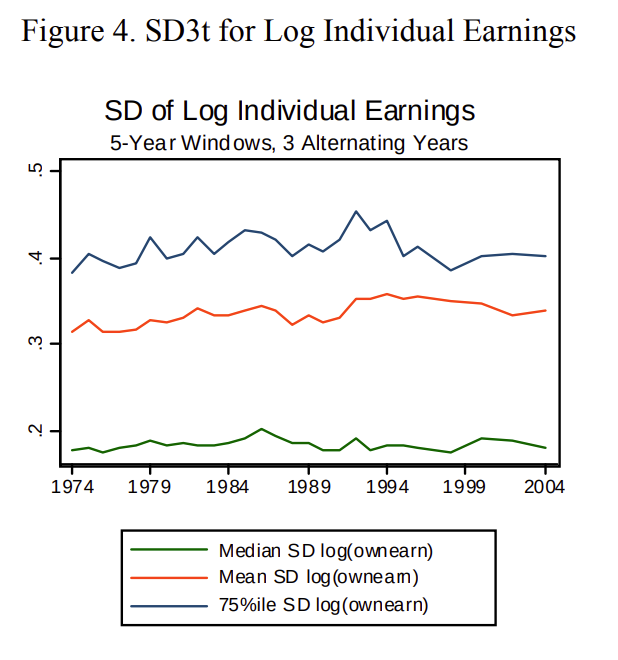

It shows:
* The volatility in log individual earnings is relatively constant over 1974 - 2004
* The median of log-earnings 3-year volatility (across individuals) is around 0.2; the mean around 0.35, and the 75th percentile around 0.4.

Using the mean value, and converting it into a single-year volatility, we get $\sigma_E = \frac{0.35}{\sqrt{3}} = 0.20$.